<a href="https://colab.research.google.com/github/Ruby-L-i-n/CSDS234_FinalProject/blob/main/SpotifyPlaylist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import


In [19]:
import numpy as np
import pandas as pd
import heapq
import random
import json
import matplotlib.pyplot as pyplot

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

###Reading Json File

In [44]:
#select 100 random playlist since the data is too large.
np.random.seed(seed = 19) #a random seed to ensure calculation is the same across methods. change to generate a different set of random numbers
numbers = np.arange(0,1000,1) #a range of numbers from 1 to 1000
sample = np.random.choice(numbers, size=100, replace=True) #randomly select 100 playlists
print(sample)

[605 622 757 354 936  19 308 330 671 834 440 534 162 901 609 266 342 306
 364 167 783 231 976 807 327 777 203 201 772 853 869 999 988 849 369 194
  53 291 313  55 872 188 869 325 416 817 708 438 220 510 465 780 467 433
 941 212 273 467 837 409 435 475 183 905 779 733 612 379 446 956 246 896
 233 803 114 191 636 671  32 575 778 727 618 556 474 789 707 597 954 907
 169  88 816 634 839 449 872 126 393 372]


In [45]:
with open("/content/mpd.slice.0-999.json") as f:
    data = json.load(f)

flattened_playlists = []
for playlist in data['playlists']:
    playlist_info = {
        'pid': playlist['pid'],
        'name': playlist.get('name', None),
        'collaborative': playlist['collaborative'],
        'modified_at': playlist['modified_at'],
        'num_tracks': playlist['num_tracks'],
        'num_albums': playlist['num_albums'],
        'num_followers': playlist['num_followers']
    }

    for track in playlist['tracks']:
        track_info = {
            'playlist_pid': playlist['pid'],
            'track_pos': track['pos'],
            'track_name': track['track_name'],
            'track_uri': track['track_uri'],
            'artist_name': track['artist_name'],
            'artist_uri': track['artist_uri'],
            'album_name': track['album_name'],
            'album_uri': track['album_uri'],
            'duration_ms': track['duration_ms']
        }
        flattened_playlists.append({**playlist_info, **track_info})

# Create a Pandas DataFrame
df = pd.DataFrame(flattened_playlists)
df.head(10)

,pid,name,collaborative,modified_at,num_tracks,num_albums,num_followers,playlist_pid,track_pos,track_name,track_uri,artist_name,artist_uri,album_name,album_uri,duration_ms
0,0,Throwbacks,false,1493424000,52,47,1,0,0,Lose Control (feat. Ciara & Fat Man Scoop),spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott,spotify:artist:2wIVse2owClT7go1WT98tk,The Cookbook,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863
1,0,Throwbacks,false,1493424000,52,47,1,0,1,Toxic,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Britney Spears,spotify:artist:26dSoYclwsYLMAKD3tpOr4,In The Zone,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800
2,0,Throwbacks,false,1493424000,52,47,1,0,2,Crazy In Love,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Beyoncé,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Dangerously In Love (Alben für die Ewigkeit),spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933
3,0,Throwbacks,false,1493424000,52,47,1,0,3,Rock Your Body,spotify:track:1AWQoqb9bSvzTjaLralEkT,Justin Timberlake,spotify:artist:31TPClRtHm23RisEBtV3X7,Justified,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266
4,0,Throwbacks,false,1493424000,52,47,1,0,4,It Wasn't Me,spotify:track:1lzr43nnXAijIGYnCT8M8H,Shaggy,spotify:artist:5EvFsr3kj42KNv97ZEnqij,Hot Shot,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600
5,0,Throwbacks,false,1493424000,52,47,1,0,5,Yeah!,spotify:track:0XUfyU2QviPAs6bxSpXYG4,Usher,spotify:artist:23zg3TcAtWQy7J6upgbUnj,Confessions,spotify:album:0vO0b1AvY49CPQyVisJLj0,250373
6,0,Throwbacks,false,1493424000,52,47,1,0,6,My Boo,spotify:track:68vgtRHr7iZHpzGpon6Jlo,Usher,spotify:artist:23zg3TcAtWQy7J6upgbUnj,Confessions,spotify:album:1RM6MGv6bcl6NrAG8PGoZk,223440
7,0,Throwbacks,false,1493424000,52,47,1,0,7,Buttons,spotify:track:3BxWKCI06eQ5Od8TY2JBeA,The Pussycat Dolls,spotify:artist:6wPhSqRtPu1UhRCDX5yaDJ,PCD,spotify:album:5x8e8UcCeOgrOzSnDGuPye,225560
8,0,Throwbacks,false,1493424000,52,47,1,0,8,Say My Name,spotify:track:7H6ev70Weq6DdpZyyTmUXk,Destiny's Child,spotify:artist:1Y8cdNmUJH7yBTd9yOvr5i,The Writing's On The Wall,spotify:album:283NWqNsCA9GwVHrJk59CG,271333
9,0,Throwbacks,false,1493424000,52,47,1,0,9,Hey Ya! - Radio Mix / Club Mix,spotify:track:2PpruBYCo4H7WOBJ7Q2EwM,OutKast,spotify:artist:1G9G7WwrXka3Z1r7aIDjI7,Speakerboxxx/The Love Below,spotify:album:1UsmQ3bpJTyK6ygoOOjG1r,235213


In [53]:
#clean the data by only using the random 100 playlists
clean_df = df.loc[df["pid"].isin(sample)]
clean_df.head()

total number of songs:  5108


,pid,name,collaborative,modified_at,num_tracks,num_albums,num_followers,playlist_pid,track_pos,track_name,track_uri,artist_name,artist_uri,album_name,album_uri,duration_ms
1104,19,melancholy,false,1430956800,85,82,1,19,0,Cold Fame,spotify:track:16UCgrePMyBPrtnBaGd4nt,Band Of Skulls,spotify:artist:4ddt8PPvmWrI9mJQy1VrIG,Baby Darling Doll Face Honey,spotify:album:324BTvXR9NMitN9KndHLKA,371360
1105,19,melancholy,false,1430956800,85,82,1,19,1,Things Behind The Sun,spotify:track:7bIpR4tyHFgGLkue8fPLjL,Nick Drake,spotify:artist:5c3GLXai8YOMid29ZEuR9y,Pink Moon,spotify:album:6LoD5uGEynY4eqstWDFKhg,234320
1106,19,melancholy,false,1430956800,85,82,1,19,2,Swim Club,spotify:track:1cMn5OQ1WlkBnw1QyfSsHw,The Cave Singers,spotify:artist:4SjCvf9Ctuz369ZKAnjkZP,No Witch,spotify:album:5BzG2vtOh1sfHyPUfnWVXC,181160
1107,19,melancholy,false,1430956800,85,82,1,19,3,Close to Nowhere,spotify:track:2XOBX2pmQc7yX4N8eQho6M,Band Of Skulls,spotify:artist:4ddt8PPvmWrI9mJQy1VrIG,Sweet Sour,spotify:album:2ixobpSRUPyIBLIvX2lA4c,272600
1108,19,melancholy,false,1430956800,85,82,1,19,4,Whispered Words (Pretty Lies),spotify:track:2dqRgUIrAX6Ptads6ttPDw,Dan Auerbach,spotify:artist:6YWdHD3R863Apw1hkx3BwC,Keep It Hid,spotify:album:1aS3ouxrqC2xAjR5LJku6M,246253


Before we start it is usful to gain some insights on the data we are working with.

In [54]:
print("total number of songs: ", len(set(clean_df["track_name"])))

total number of songs:  5108


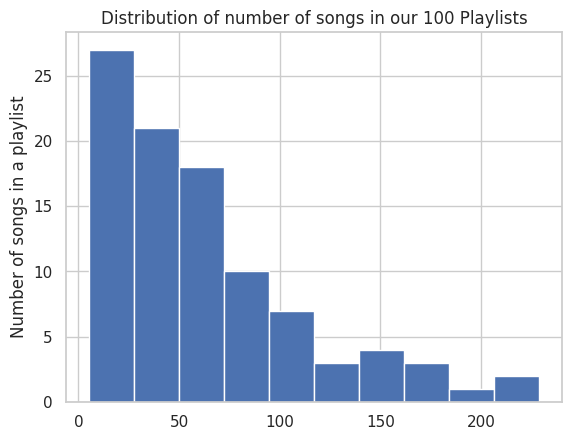

In [55]:
pyplot.hist(clean_df['pid'].value_counts())
pyplot.title("Distribution of number of songs in our 100 Playlists")
pyplot.ylabel("Count")
pyplot.ylabel("Number of songs in a playlist")
pyplot.show()

Text(0.5, 0, 'Total songs across playlists')

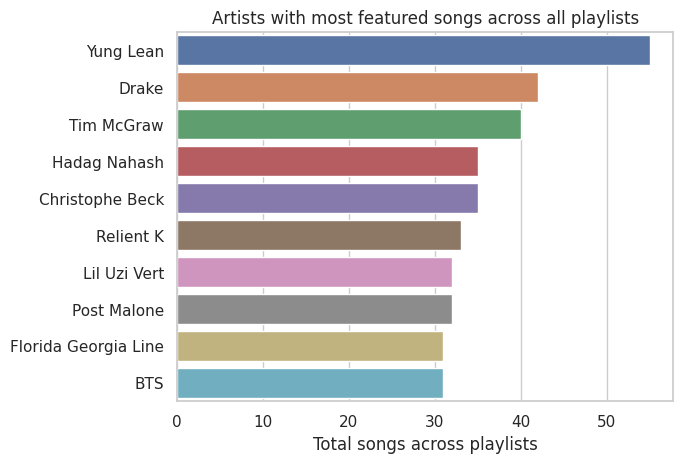

In [48]:
# Checking which artists are featured most across all playlists
values = list(clean_df['artist_name'].value_counts())
names = clean_df['artist_name'].value_counts().index.tolist()

ax = sns.barplot(y=names[0:10], x=values[0:10])
ax.set_title('Artists with most featured songs across all playlists')
ax.set_xlabel('Total songs across playlists')

In [57]:
#create a sparse matrix of song in playlist

